In [1]:
import os
import errno
import argparse
import numpy as np
import cv2
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as plt

2022-03-21 22:25:51.531965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 22:25:51.532073: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


2022-03-21 22:26:27.376438: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-21 22:26:27.376542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ozmonday): /proc/driver/nvidia/version does not exist


In [3]:
def _run_in_batches(f, data_dict, out, batch_size):
    data_len = len(out)
    num_batches = int(data_len / batch_size)

    s, e = 0, 0
    for i in range(num_batches):
        s, e = i * batch_size, (i + 1) * batch_size
        batch_data_dict = {k: v[s:e] for k, v in data_dict.items()}
        out[s:e] = f(batch_data_dict)
    if e < len(out):
        batch_data_dict = {k: v[e:] for k, v in data_dict.items()}
        out[e:] = f(batch_data_dict)


In [4]:
def extract_image_patch(image, bbox, patch_shape):
    """Extract image patch from bounding box.

    Parameters
    ----------
    image : ndarray
        The full image.
    bbox : array_like
        The bounding box in format (x, y, width, height).
    patch_shape : Optional[array_like]
        This parameter can be used to enforce a desired patch shape
        (height, width). First, the `bbox` is adapted to the aspect ratio
        of the patch shape, then it is clipped at the image boundaries.
        If None, the shape is computed from :arg:`bbox`.

    Returns
    -------
    ndarray | NoneType
        An image patch showing the :arg:`bbox`, optionally reshaped to
        :arg:`patch_shape`.
        Returns None if the bounding box is empty or fully outside of the image
        boundaries.

    """
    bbox = np.array(bbox)
    if patch_shape is not None:
        # correct aspect ratio to patch shape
        target_aspect = float(patch_shape[1]) / patch_shape[0]
        new_width = target_aspect * bbox[3]
        bbox[0] -= (new_width - bbox[2]) / 2
        bbox[2] = new_width

    # convert to top left, bottom right
    bbox[2:] += bbox[:2]
    bbox = bbox.astype(np.int)
    
    # clip at image boundaries
    bbox[:2] = np.maximum(0, bbox[:2])
    bbox[2:] = np.minimum(np.asarray(image.shape[:2][::-1]) - 1, bbox[2:])
    if np.any(bbox[:2] >= bbox[2:]):
        return None
    sx, sy, ex, ey = bbox
    print(f'pacth{bbox}')
    image = image[sy:ey, sx:ex]
    image = cv2.resize(image, tuple(patch_shape[::-1]))
    return image


In [5]:
class ImageEncoder(object):

    def __init__(self, checkpoint_filename, input_name="images",
                 output_name="features"):
        self.session = tf.Session()
        with tf.gfile.GFile(checkpoint_filename, "rb") as file_handle:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(file_handle.read())
        tf.import_graph_def(graph_def, name="net")
        self.input_var = tf.get_default_graph().get_tensor_by_name(
            "%s:0" % input_name)
        self.output_var = tf.get_default_graph().get_tensor_by_name(
            "%s:0" % output_name)

        assert len(self.output_var.get_shape()) == 2
        assert len(self.input_var.get_shape()) == 4
        self.feature_dim = self.output_var.get_shape().as_list()[-1]
        self.image_shape = self.input_var.get_shape().as_list()[1:]

    def __call__(self, data_x, batch_size=32):
        out = np.zeros((len(data_x), self.feature_dim), np.float32)
        _run_in_batches(
            lambda x: self.session.run(self.output_var, feed_dict=x),
            {self.input_var: data_x}, out, batch_size)
        return out

In [6]:

def create_box_encoder(model_filename, input_name="images",
                       output_name="features", batch_size=32):
    image_encoder = ImageEncoder(model_filename, input_name, output_name)
    image_shape = image_encoder.image_shape
    print(image_shape[:2])

    def encoder(image, boxes):
        image_patches = []
        for _, row in boxes.iterrows():
            x1, y1, _, _, cls, score, w, h = row.values
            box = [x1,y1,w,h]
            print(box)
            patch = extract_image_patch(image, box, image_shape[:2])
            plt.imshow(patch)
            if patch is None:
                print("WARNING: Failed to extract image patch: %s." % str(box))
                patch = np.random.uniform(
                    0., 255., image_shape).astype(np.uint8)
            image_patches.append(patch)
        image_patches = np.asarray(image_patches)
        return image_encoder(image_patches, batch_size)

    return encoder

In [7]:

def generate_detections(encoder, mot_dir, output_dir, detection_dir=None):
    """Generate detections with features.

    Parameters
    ----------
    encoder : Callable[image, ndarray] -> ndarray
        The encoder function takes as input a BGR color image and a matrix of
        bounding boxes in format `(x, y, w, h)` and returns a matrix of
        corresponding feature vectors.
    mot_dir : str
        Path to the MOTChallenge directory (can be either train or test).
    output_dir
        Path to the output directory. Will be created if it does not exist.
    detection_dir
        Path to custom detections. The directory structure should be the default
        MOTChallenge structure: `[sequence]/det/det.txt`. If None, uses the
        standard MOTChallenge detections.

    """
    if detection_dir is None:
        detection_dir = mot_dir
    try:
        os.makedirs(output_dir)
    except OSError as exception:
        if exception.errno == errno.EEXIST and os.path.isdir(output_dir):
            pass
        else:
            raise ValueError(
                "Failed to created output directory '%s'" % output_dir)

    for sequence in os.listdir(mot_dir):
        print("Processing %s" % sequence)
        sequence_dir = os.path.join(mot_dir, sequence)

        image_dir = os.path.join(sequence_dir, "img1")
        image_filenames = {
            int(os.path.splitext(f)[0]): os.path.join(image_dir, f)
            for f in os.listdir(image_dir)}

        detection_file = os.path.join(
            detection_dir, sequence, "det/det.txt")
        detections_in = np.loadtxt(detection_file, delimiter=',')
        detections_out = []

        frame_indices = detections_in[:, 0].astype(np.int)
        min_frame_idx = frame_indices.astype(np.int).min()
        max_frame_idx = frame_indices.astype(np.int).max()
        for frame_idx in range(min_frame_idx, max_frame_idx + 1):
            print("Frame %05d/%05d" % (frame_idx, max_frame_idx))
            mask = frame_indices == frame_idx
            rows = detections_in[mask]

            if frame_idx not in image_filenames:
                print("WARNING could not find image for frame %d" % frame_idx)
                continue
            bgr_image = cv2.imread(
                image_filenames[frame_idx], cv2.IMREAD_COLOR)
            features = encoder(bgr_image, rows[:, 2:6].copy())
            detections_out += [np.r_[(row, feature)] for row, feature
                               in zip(rows, features)]

        output_filename = os.path.join(output_dir, "%s.npy" % sequence)
        np.save(
            output_filename, np.asarray(detections_out), allow_pickle=False)


In [8]:
def parse_args():
    """Parse command line arguments.
    """
    parser = argparse.ArgumentParser(description="Re-ID feature extractor")
    parser.add_argument(
        "--model",
        default="resources/networks/mars-small128.pb",
        help="Path to freezed inference graph protobuf.")
    parser.add_argument(
        "--mot_dir", help="Path to MOTChallenge directory (train or test)",
        required=True)
    parser.add_argument(
        "--detection_dir", help="Path to custom detections. Defaults to "
        "standard MOT detections Directory structure should be the default "
        "MOTChallenge structure: [sequence]/det/det.txt", default=None)
    parser.add_argument(
        "--output_dir", help="Output directory. Will be created if it does not"
        " exist.", default="detections")
    return parser.parse_args()


In [9]:
model_filename = '../model_data/mars-small128.pb'

In [10]:
encoder = create_box_encoder(model_filename, batch_size=1)

2022-03-21 22:26:58.860823: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[128, 64]


YOLO Model

In [15]:
from sys import path
path.insert(0, '..')
import utill
import config
import layer
import json

In [12]:
with open('../assets/dataset/gt_train.txt') as file:
  data = json.load(file)

data_training = data[:88000]
data_validation = data [88000:]

print("Data length : {0}".format(len(data)))

Data length : 110000


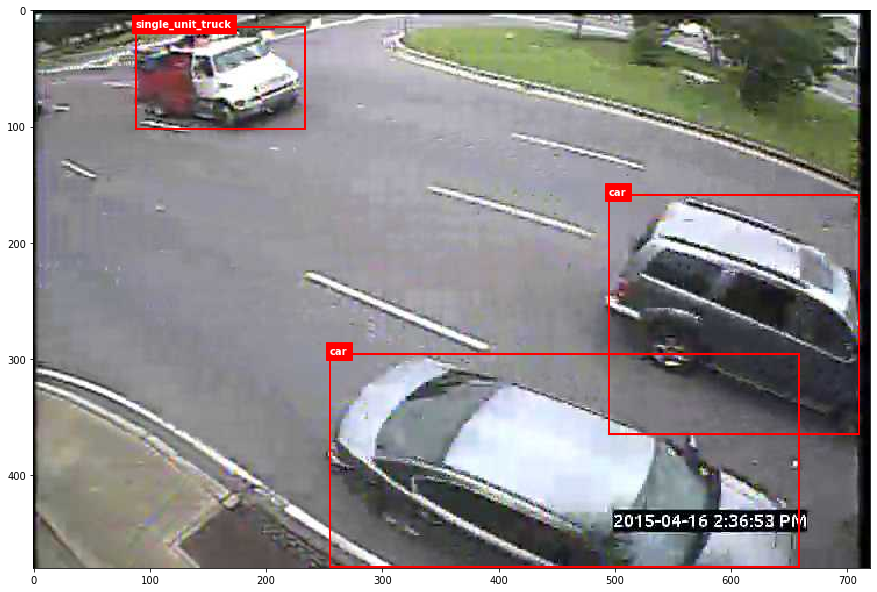

In [13]:
s = 11
img = utill.open_image(os.path.join('../assets/dataset/train',data_validation[s]['filename']), False)
utill.draw_image(img, data_validation[s])

In [14]:
class_name = [line.strip() for line in open('../assets/class_name.txt').readlines()]
interpreter = tf.lite.Interpreter(model_path='../assets/yolo-v4-car-lite-503.130-125.92.tflite')
interpreter.allocate_tensors()

In [36]:
def tflite_predict(img, config, class_name, interpreter, filtter_threshold=0.7):
    anchors = np.array(config['anchors']).reshape((2, 6, 2))
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    exp_img = utill.img_process_tflite(img, input_details[0]['shape'])
    interpreter.set_tensor(input_details[0]['index'], exp_img)
    interpreter.invoke()
    outputs = [interpreter.get_tensor(output_details[1]['index']), interpreter.get_tensor(output_details[0]['index'])]
    outputs = layer.yolo_detector_lite(outputs, anchors, len(class_name) , config['strides'], config['xyscale'])
    outputs = nms(outputs, config['image_size'], len(class_name), config['iou_threshold'], config['score_threshold'])
    # boxes = utill.get_detection_data(outputs, img.shape, class_name)
    # boxes = utill.filtter(boxes, filtter_threshold)
    # features = encoder(img, boxes)
    # dtc = []
    # for idx in range(len(boxes)):
    #     b = [boxes.iloc[idx,0], boxes.iloc[idx,1], boxes.iloc[idx,6], boxes.iloc[idx,7]]
    #     s = boxes.iloc[idx,5]
    #     c = boxes.iloc[idx,4]
    #     f = features[idx]
    #     dtc.append(Detection(b, s, c, f))

    return outputs


In [37]:
outputs = tflite_predict(img, config.cfg_lite, class_name, interpreter)

boxes (1, 5070, 4)
class (1, 5070, 11)
nms boxes (1, 100, 4)
class (1, 100)


In [35]:

def nms(model_ouputs, input_shape, num_class, iou_threshold=0.413, score_threshold=0.3):
    """
    Apply Non-Maximum suppression
    ref: https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression
    :param model_ouputs: yolo model model_ouputs
    :param input_shape: size of input image
    :return: nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections
    """
    bs = tf.shape(model_ouputs[0])[0] #beach size
    boxes = tf.zeros((bs, 0, 4))
    confidence = tf.zeros((bs, 0, 1))
    class_probabilities = tf.zeros((bs, 0, num_class))

    for output_idx in range(0, len(model_ouputs), 4):
        output_xy = model_ouputs[output_idx]
        output_conf = model_ouputs[output_idx + 1]
        output_classes = model_ouputs[output_idx + 2]
        boxes = tf.concat([boxes, tf.reshape(output_xy, (bs, -1, 4))], axis=1)
        confidence = tf.concat([confidence, tf.reshape(output_conf, (bs, -1, 1))], axis=1)
        class_probabilities = tf.concat([class_probabilities, tf.reshape(output_classes, (bs, -1, num_class))], axis=1)

    scores = confidence * class_probabilities
    boxes = boxes / input_shape[0]
    print(f'boxes {boxes.shape}')
    print(f'class {class_probabilities.shape}')
    boxes = tf.expand_dims(boxes, axis=-2)

    #print(f'nms iou: {iou_threshold} score: {score_threshold}')
    (nmsed_boxes,      # [bs, max_detections, 4]
     nmsed_scores,     # [bs, max_detections]
     nmsed_classes,    # [bs, max_detections]
     valid_detections  # [batch_size]
     ) = tf.image.combined_non_max_suppression(
        boxes=boxes,  # y1x1, y2x2 [0~1]
        scores=scores,
        max_output_size_per_class=100,
        max_total_size=100,  # max_boxes: Maximum nmsed_boxes in a single img.
        iou_threshold=iou_threshold,  # iou_threshold: Minimum overlap that counts as a valid detection.
        score_threshold=score_threshold,  # # Minimum confidence that counts as a valid detection.
    )
    print(f'nms boxes {nmsed_boxes.shape}')
    print(f'class {nmsed_classes.shape}')
    return nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections


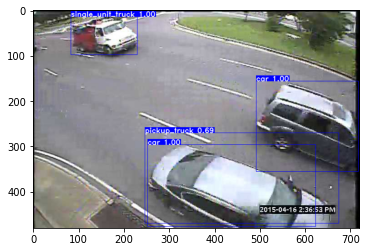

In [30]:
plt.imshow(frame)

In [28]:
print(boxes)


    x1   y1   x2   y2         class_name     score    w    h
0  252  296  622  476                car  0.999845  370  180
1  491  156  716  355                car  0.998505  225  199
2   83   14  229   98  single_unit_truck  0.997024  146   84
3  246  270  673  469       pickup_truck  0.689477  427  199


In [35]:
img.shape

(480, 720, 3)

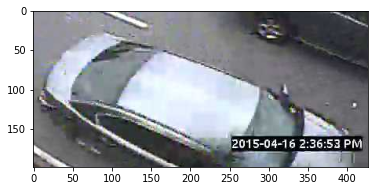

In [44]:
patch = []
for _, row in boxes.iterrows():
  x1, y1, x2, y2, cls, score, w, h = row.values

  new_img = img[y1:y2, x1:x2]
  patch.append(new_img)


len(patch)
plt.imshow(patch[3])

[252, 296, 370, 180]
[491, 156, 225, 199]
[83, 14, 146, 84]
[246, 270, 427, 199]


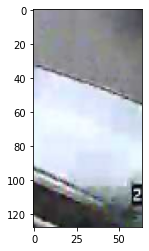

In [34]:
feture = encoder(img, boxes)